# 导入数据

In [21]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Load
bond_yield_df = pd.read_csv('data/FE_BONDYIELDSD.csv')
three_factor_df = pd.read_csv('data/RESSET_THRFACDAT_DAILY_1.csv')
stock_data_df = pd.read_csv('data/stock/sz002681.csv')

(bond_yield_df.head(), three_factor_df.head(), stock_data_df.head())

(    StatsDate  OneYearBondYield
 0  2015-01-04            3.2566
 1  2015-01-05            3.2568
 2  2015-01-06            3.2642
 3  2015-01-07            3.2088
 4  2015-01-08            3.1959,
    交易所标识_Exchflg 市场标识_Mktflg     日期_Date  市场溢酬因子__流通市值加权_Rmrf_tmv  \
 0              2           A  2013-01-04                  -0.0055   
 1              2           A  2013-01-07                   0.0082   
 2              2           A  2013-01-08                   0.0107   
 3              2           A  2013-01-09                   0.0039   
 4              2           A  2013-01-10                   0.0048   
 
    市值因子__流通市值加权_Smb_tmv  账面市值比因子__流通市值加权_Hml_tmv  市场溢酬因子__总市值加权_Rmrf_mc  \
 0               -0.0001                   0.0096                -0.0046   
 1                0.0090                  -0.0025                 0.0089   
 2                0.0072                  -0.0076                 0.0115   
 3               -0.0016                  -0.0066                 0.0032   

## 中国国债收益率（bond_yield_df）
`StatsDate` 日期
`OneYearBondYield` 一年期国债的收益率
    
## 三因子历史数据（three_factor_df）

`市场溢酬因子__流通市值加权_Rmrf_tmv`
`市值因子__流通市值加权_Smb_tmv`
`账面市值比因子__流通市值加权_Hml_tmv`

## 股票历史数据（stock_data_df）
`close` 收盘价

# 预处理
选取2023年之前的数据作训练集
合并数据

In [22]:
bond_yield_df['StatsDate'] = pd.to_datetime(bond_yield_df['StatsDate'])
three_factor_df['日期_Date'] = pd.to_datetime(three_factor_df['日期_Date'])
stock_data_df['date'] = pd.to_datetime(stock_data_df['date'])

three_factor_df.drop(columns=['交易所标识_Exchflg', '市场标识_Mktflg', 'Unnamed: 9'], inplace=True)


bond_yield_pre_2023 = bond_yield_df[bond_yield_df['StatsDate'].dt.year < 2023]
three_factor_pre_2023 = three_factor_df[three_factor_df['日期_Date'].dt.year < 2023]
stock_data_pre_2023 = stock_data_df[stock_data_df['date'].dt.year < 2023]


merged_data_pre_2023 = stock_data_pre_2023.merge(three_factor_pre_2023, left_on='date', right_on='日期_Date', how='inner')
merged_data_pre_2023 = merged_data_pre_2023.merge(bond_yield_pre_2023, left_on='date', right_on='StatsDate', how='inner')


model_data_pre_2023 = merged_data_pre_2023[['date', 'close', '市场溢酬因子__流通市值加权_Rmrf_tmv', '市值因子__流通市值加权_Smb_tmv', '账面市值比因子__流通市值加权_Hml_tmv', 'OneYearBondYield']]

# Rename
model_data_pre_2023.columns = ['Date', 'Stock_Close', 'Market_Risk_Premium', 'Size_Premium', 'Value_Premium', 'One_Year_Bond_Yield']

model_data_pre_2023.head()

,Date,Stock_Close,Market_Risk_Premium,Size_Premium,Value_Premium,One_Year_Bond_Yield
0,2015-01-05,27.36,0.0182,-0.0224,0.0066,3.2568
1,2015-01-05,27.36,0.0183,-0.0229,0.0072,3.2568
2,2015-01-05,27.36,0.0217,-0.0183,-0.0039,3.2568
3,2015-01-06,28.09,0.0181,0.0050,-0.0251,3.2642
4,2015-01-06,28.09,0.0181,0.0052,-0.0253,3.2642


In [23]:
# Remove duplicates
model_data_pre_2023.drop_duplicates(subset=['Date'], inplace=True)
model_data_pre_2023.head()

,Date,Stock_Close,Market_Risk_Premium,Size_Premium,Value_Premium,One_Year_Bond_Yield
0,2015-01-05,27.36,0.0182,-0.0224,0.0066,3.2568
3,2015-01-06,28.09,0.0181,0.0050,-0.0251,3.2642
6,2015-01-07,27.56,-0.0029,0.0016,0.0026,3.2088
9,2015-01-08,29.36,-0.0045,0.0059,-0.0118,3.1959
12,2015-01-09,28.70,-0.0062,0.0000,-0.0046,3.1944


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

计算超额收益率,无风险利率用国债收益率
$$ \text{Daily return} = \frac{\text{Closing price today} - \text{Closing price yesterday}}{\text{Closing price yesterday}} $$
转化成超额收益率
$$ \text{Excess return} = \text{Daily return} - \frac{\text{One year bond yield}}{365} $$


In [25]:
model_data_pre_2023['Stock_Return'] = model_data_pre_2023['Stock_Close'].pct_change()

model_data_pre_2023['Daily_Bond_Yield'] = model_data_pre_2023['One_Year_Bond_Yield'] / 365

model_data_pre_2023['Excess_Return'] = model_data_pre_2023['Stock_Return'] - model_data_pre_2023['Daily_Bond_Yield']

model_data_pre_2023 = model_data_pre_2023.dropna()

model_data_pre_2023.head()

,Date,Stock_Close,Market_Risk_Premium,Size_Premium,Value_Premium,One_Year_Bond_Yield,Stock_Return,Daily_Bond_Yield,Excess_Return
3,2015-01-06,28.09,0.0181,0.0050,-0.0251,3.2642,0.026681,0.008943,0.017738
6,2015-01-07,27.56,-0.0029,0.0016,0.0026,3.2088,-0.018868,0.008791,-0.027659
9,2015-01-08,29.36,-0.0045,0.0059,-0.0118,3.1959,0.065312,0.008756,0.056556
12,2015-01-09,28.70,-0.0062,0.0000,-0.0046,3.1944,-0.022480,0.008752,-0.031231
15,2015-01-12,28.96,-0.0072,-0.0077,-0.0179,3.1953,0.009059,0.008754,0.000305


# OLS拟合

In [26]:
X = model_data_pre_2023[['Market_Risk_Premium', 'Size_Premium', 'Value_Premium']]
y = model_data_pre_2023['Excess_Return']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

lr_model = LinearRegression()

lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

(r2, mse)

(0.23535780791093797, 0.0017334150212690632)

R-squared: R2=0.1066
Mean Squared Error: MSE = 0.000406

In [27]:
beta_coefficients = lr_model.coef_
beta_coefficients_dict = {
    'Market_Risk_Premium_Beta': beta_coefficients[0],
    'Size_Premium_Beta': beta_coefficients[1],
    'Value_Premium_Beta': beta_coefficients[2]
}

beta_coefficients_dict

{'Market_Risk_Premium_Beta': 1.0591772583707066,
 'Size_Premium_Beta': 0.6269919867199567,
 'Value_Premium_Beta': -0.13440077389156063}

市场风险溢酬因子 Beta（Market_Risk_Premium_Beta）: 0.3712
规模溢酬因子 Beta（Size_Premium_Beta）: 0.3655
价值溢酬因子 Beta（Value_Premium_Beta）: 0.1076

In [28]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

time_series_data = model_data_pre_2023.drop_duplicates(subset='Date', keep='last').set_index('Date')

time_series_data = time_series_data.asfreq('D').fillna(method='ffill')

# 检验时间序列数据的平稳性，确定最佳的ARIMA模型

In [29]:
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')  # .dropna() handles differenced data
    labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val
    print(out.to_string())  # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
    print("\n")

adf_test(time_series_data['Market_Risk_Premium'], 'Market Risk Premium')
adf_test(time_series_data['Size_Premium'], 'Size Premium')
adf_test(time_series_data['Value_Premium'], 'Value Premium')

auto_arima_results = {}

for column in ['Market_Risk_Premium', 'Size_Premium', 'Value_Premium']:
    print(f"Running auto_arima for {column}")
    auto_arima_result = auto_arima(time_series_data[column], seasonal=False, stepwise=True, suppress_warnings=True, error_action="ignore", max_order=None, trace=True)
    auto_arima_results[column] = auto_arima_result
    print(f"Best ARIMA order for {column}: {auto_arima_result.order}")
    print("\n")

Augmented Dickey-Fuller Test: Market Risk Premium
ADF test statistic     -9.103040e+00
p-value                 3.562931e-15
# lags used             2.800000e+01
# observations          2.887000e+03
critical value (1%)    -3.432617e+00
critical value (5%)    -2.862542e+00
critical value (10%)   -2.567303e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Augmented Dickey-Fuller Test: Size Premium
ADF test statistic     -1.713646e+01
p-value                 7.092344e-30
# lags used             6.000000e+00
# observations          2.909000e+03
critical value (1%)    -3.432600e+00
critical value (5%)    -2.862534e+00
critical value (10%)   -2.567299e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Augmented Dickey-Fuller Test: Value Premium
ADF test statistic     -1.567415e+01
p-value                 1.500078e-28
# lags used             8.000000e+00
# observ

## Best ARIMA order for Market_Risk_Premium: (1, 0, 1)
## Best ARIMA order for Size_Premium: (2, 1, 2)
## Best ARIMA order for Value_Premium: (1, 0, 1)

In [30]:
# def fit_arima_and_forecast(time_series, order=(1, 0, 0), start_date='2023-01-01', end_date='2023-12-31'):
#     model = ARIMA(time_series, order=order)
#     model_fit = model.fit()
#     forecast = model_fit.get_forecast(steps=365)  # Assuming 365 days in 2023
#     forecast_index = pd.date_range(start_date, end_date, freq='D')
#     forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
#     return forecast_series, model_fit

def fit_arima_and_forecast(time_series, p, d, q, start_date='2023-01-01', end_date='2023-12-31'):
    order = (p, d, q)  # Set the order of the ARIMA model with the provided parameters
    model = ARIMA(time_series, order=order)
    model_fit = model.fit()
    forecast = model_fit.get_forecast(steps=365)  # Assuming 365 days in 2023
    forecast_index = pd.date_range(start_date, end_date, freq='D')
    forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)
    return forecast_series, model_fit

market_risk_premium_forecast, market_risk_premium_model = fit_arima_and_forecast(time_series_data['Market_Risk_Premium'], 1, 0, 1)
size_premium_forecast, size_premium_model = fit_arima_and_forecast(time_series_data['Size_Premium'], 2, 1, 2)
value_premium_forecast, value_premium_model = fit_arima_and_forecast(time_series_data['Value_Premium'], 1, 0, 1)

market_risk_premium_forecast.head(), size_premium_forecast.head(), value_premium_forecast.head()

(2023-01-01    0.001015
 2023-01-02    0.000833
 2023-01-03    0.000736
 2023-01-04    0.000684
 2023-01-05    0.000656
 Freq: D, Name: predicted_mean, dtype: float64,
 2023-01-01    0.001522
 2023-01-02   -0.000250
 2023-01-03    0.000058
 2023-01-04   -0.000764
 2023-01-05   -0.000369
 Freq: D, Name: predicted_mean, dtype: float64,
 2023-01-01    0.000247
 2023-01-02    0.000106
 2023-01-03    0.000025
 2023-01-04   -0.000021
 2023-01-05   -0.000047
 Freq: D, Name: predicted_mean, dtype: float64)

In [31]:
stock_data_2023_df = pd.read_csv('data/stock/sz002681.csv')
bond_yield_2023_df = pd.read_csv('data/FE_BONDYIELDSD.csv')
three_factors_2023_df = pd.read_csv('data/RESSET_THRFACDAT_DAILY_1.csv')

stock_data_2023_df['date'] = pd.to_datetime(stock_data_2023_df['date'])
bond_yield_2023_df['StatsDate'] = pd.to_datetime(bond_yield_2023_df['StatsDate'])
three_factors_2023_df['日期_Date'] = pd.to_datetime(three_factors_2023_df['日期_Date'])

stock_data_2023 = stock_data_2023_df[stock_data_2023_df['date'].dt.year == 2023]
bond_yield_2023 = bond_yield_2023_df[bond_yield_2023_df['StatsDate'].dt.year == 2023]
three_factors_2023 = three_factors_2023_df[three_factors_2023_df['日期_Date'].dt.year == 2023]

(stock_data_2023.shape, bond_yield_2023.shape, three_factors_2023.shape)

((224, 20), (234, 2), (546, 10))

In [32]:
stock_data_2023['daily_return'] = stock_data_2023['close'].pct_change()

bond_yield_2023['daily_yield'] = bond_yield_2023['OneYearBondYield'] / 365

merged_data_2023 = stock_data_2023.merge(bond_yield_2023, left_on='date', right_on='StatsDate', how='left')

merged_data_2023['excess_return'] = merged_data_2023['daily_return'] - merged_data_2023['daily_yield']

merged_data_2023.head()

,code,date,open,high,low,close,change,volume,money,traded_market_value,...,PE_TTM,PS_TTM,PC_TTM,PB,adjust_price_f,daily_return,StatsDate,OneYearBondYield,daily_yield,excess_return
0,sz002681,2023-01-03,3.77,3.80,3.72,3.79,0.005305,14383980.0,54096936.0,4.809557e+09,...,36.508089,2.489994,49.001834,2.931924,3.79,NaN,2023-01-03,2.1452,0.005877,NaN
1,sz002681,2023-01-04,3.79,3.81,3.73,3.78,-0.002639,12644069.0,47587007.0,4.796867e+09,...,36.411761,2.483424,48.872542,2.924188,3.78,-0.002639,2023-01-04,2.1228,0.005816,-0.008454
2,sz002681,2023-01-05,3.78,3.83,3.74,3.78,0.000000,16447123.0,62354504.0,4.796867e+09,...,36.411761,2.483424,48.872542,2.924188,3.78,0.000000,2023-01-05,2.1141,0.005792,-0.005792
3,sz002681,2023-01-06,3.75,3.82,3.75,3.77,-0.002646,12236432.0,46291503.0,4.784177e+09,...,36.315434,2.476854,48.743249,2.916452,3.77,-0.002646,2023-01-06,2.1352,0.005850,-0.008495
4,sz002681,2023-01-09,3.77,3.93,3.75,3.93,0.042440,18196694.0,69454333.0,4.987219e+09,...,37.856672,2.581972,50.811928,3.040228,3.93,0.042440,2023-01-09,2.1423,0.005869,0.036571


In [33]:
three_factors_2023_renamed = three_factors_2023.rename(columns={
    '市场溢酬因子__流通市值加权_Rmrf_tmv': 'market_risk_premium',
    '市值因子__流通市值加权_Smb_tmv': 'size_premium',
    '账面市值比因子__流通市值加权_Hml_tmv': 'value_premium'
})

final_data_2023 = merged_data_2023.merge(three_factors_2023_renamed[['日期_Date', 'market_risk_premium', 'size_premium', 'value_premium']], left_on='date', right_on='日期_Date', how='left')

final_data_2023 = final_data_2023[['date', 'excess_return', 'market_risk_premium', 'size_premium', 'value_premium']].dropna()

final_data_2023.head()

,date,excess_return,market_risk_premium,size_premium,value_premium
3,2023-01-04,-0.008454,0.0003,0.0071,0.0097
4,2023-01-04,-0.008454,0.0003,0.0074,0.0093
5,2023-01-04,-0.008454,0.0048,-0.0059,-0.0083
6,2023-01-05,-0.005792,0.0164,-0.0130,-0.0136
7,2023-01-05,-0.005792,0.0164,-0.0128,-0.0136


In [34]:
stock_data_2023.loc[:, 'daily_return'] = stock_data_2023['close'].pct_change()
bond_yield_2023.loc[:, 'daily_yield'] = bond_yield_2023['OneYearBondYield'] / 365

final_data_2023_cleaned = final_data_2023.drop_duplicates(subset='date', keep='last')

from sklearn.metrics import mean_squared_error

mse_market_risk_premium = mean_squared_error(
    final_data_2023_cleaned['market_risk_premium'], market_risk_premium_forecast.reindex(final_data_2023_cleaned['date'])
)
mse_size_premium = mean_squared_error(
    final_data_2023_cleaned['size_premium'], size_premium_forecast.reindex(final_data_2023_cleaned['date'])
)
mse_value_premium = mean_squared_error(
    final_data_2023_cleaned['value_premium'], value_premium_forecast.reindex(final_data_2023_cleaned['date'])
)

(mse_market_risk_premium, mse_size_premium, mse_value_premium)

(5.41288045096567e-05, 1.9768630665522356e-05, 3.950221792646166e-05)

In [35]:
beta_coefficients = {
    'market_risk_premium_beta': beta_coefficients_dict['Market_Risk_Premium_Beta'],
    'size_premium_beta': beta_coefficients_dict['Size_Premium_Beta'],
    'value_premium_beta': beta_coefficients_dict['Value_Premium_Beta']
}

final_data_2023_cleaned['predicted_excess_return'] = (
    beta_coefficients['market_risk_premium_beta'] * final_data_2023_cleaned['market_risk_premium'] +
    beta_coefficients['size_premium_beta'] * final_data_2023_cleaned['size_premium'] +
    beta_coefficients['value_premium_beta'] * final_data_2023_cleaned['value_premium']
)

mse_excess_return = mean_squared_error(
    final_data_2023_cleaned['excess_return'], final_data_2023_cleaned['predicted_excess_return']
)

r2 = r2_score(final_data_2023_cleaned['excess_return'], final_data_2023_cleaned['predicted_excess_return'])

mse_excess_return, r2

(0.0009250226809773055, 0.017950848551421705)

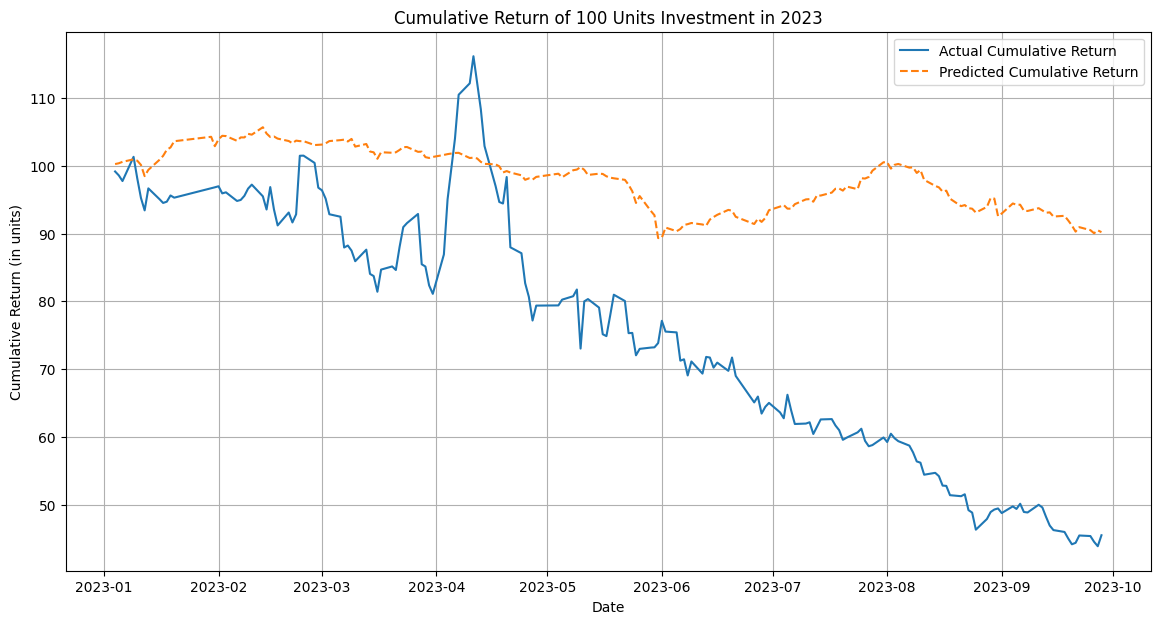

In [36]:
import matplotlib.pyplot as plt

initial_investment = 100

final_data_2023_cleaned['cumulative_actual_return'] = (1 + final_data_2023_cleaned['excess_return']).cumprod() * initial_investment
final_data_2023_cleaned['cumulative_predicted_return'] = (1 + final_data_2023_cleaned['predicted_excess_return']).cumprod() * initial_investment

plt.figure(figsize=(14, 7))
plt.plot(final_data_2023_cleaned['date'], final_data_2023_cleaned['cumulative_actual_return'], label='Actual Cumulative Return')
plt.plot(final_data_2023_cleaned['date'], final_data_2023_cleaned['cumulative_predicted_return'], label='Predicted Cumulative Return', linestyle='--')
plt.title('Cumulative Return of 100 Units Investment in 2023')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (in units)')
plt.legend()
plt.grid(True)
plt.show()

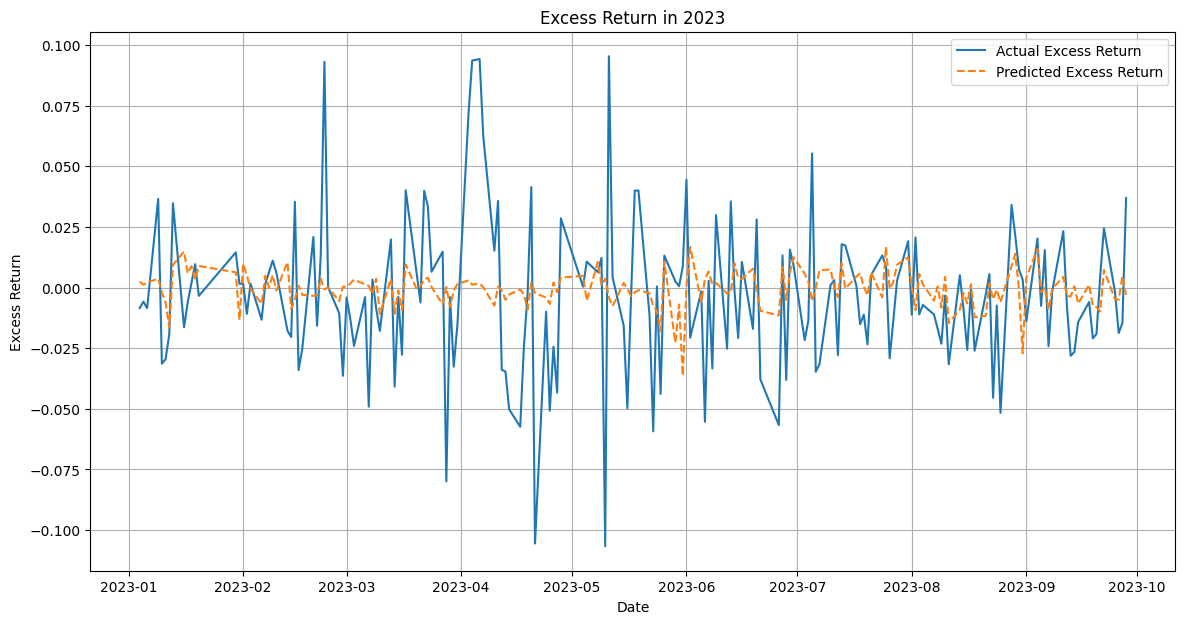

In [37]:
plt.figure(figsize=(14, 7))
plt.plot(final_data_2023_cleaned['date'], final_data_2023_cleaned['excess_return'], label='Actual Excess Return')
plt.plot(final_data_2023_cleaned['date'], final_data_2023_cleaned['predicted_excess_return'], label='Predicted Excess Return', linestyle='--')
plt.title('Excess Return in 2023')
plt.xlabel('Date')
plt.ylabel('Excess Return')
plt.legend()
plt.grid(True)
plt.show()


In [38]:
# 首先检查两个数据集在日期上是否对齐
# 假设 'date' 是两个数据集中的日期列
aligned_dates = final_data_2023_cleaned['date'].isin(stock_data_2023['date'])

if not aligned_dates.all():
    # 若日期不完全对齐，找出不对齐的日期
    misaligned_dates = final_data_2023_cleaned['date'][~aligned_dates]
    print("Misaligned dates:", misaligned_dates.tolist())

    # 将两个数据集对齐
    # 可以根据具体情况选择保留交集或其他处理方式
    # 这里我们选择保留两个数据集共有的日期
    final_data_2023_cleaned = final_data_2023_cleaned[aligned_dates]
    stock_data_2023 = stock_data_2023[stock_data_2023['date'].isin(final_data_2023_cleaned['date'])]

In [39]:
import pandas as pd
from datetime import datetime, timedelta

# 初始化参数
initial_capital = 10000
cash = initial_capital
investment_period = 7  # 交易周期
shares_held = 0  # 持有的股票数量
portfolio_values = []  # 用于记录投资组合价值

# 交易模拟
for i in range(0, len(final_data_2023_cleaned), investment_period):
    period_data = final_data_2023_cleaned.iloc[i:i + investment_period]

    # 计算期间预测的超额回报总和
    total_predicted_return = period_data['predicted_excess_return'].sum()

    stock_prices = stock_data_2023['close']

    # 若预测收益为正，用所有现金买入
    if total_predicted_return > 0:
        if cash > 0:
            buy_price = stock_prices.iloc[0]  # 假设以周期开始的价格买入
            shares_bought = cash / buy_price
            shares_held += shares_bought
            cash = 0  # 使用所有现金买入后，现金余额为0

    # 若预测收益为负，卖出一半持仓
    elif total_predicted_return < 0:
        if shares_held > 0:
            sell_price = stock_prices.iloc[-1]  # 假设以周期结束的价格卖出
            shares_sold = shares_held / 2
            cash += shares_sold * sell_price
            shares_held -= shares_sold

    # 计算周期结束时的投资组合价值
    end_price = stock_prices.iloc[-1]  # 假设以周期结束的价格计算价值
    portfolio_value = cash + (shares_held * end_price)
    portfolio_values.append(portfolio_value)

# 计算最终的投资组合价值
final_portfolio_value = portfolio_values[-1] if portfolio_values else initial_capital

# 计算收益率
return_on_investment = (final_portfolio_value - initial_capital) / initial_capital * 100
print(f"Final portfolio value: {return_on_investment:.2f}%")


Final portfolio value: 280.26%


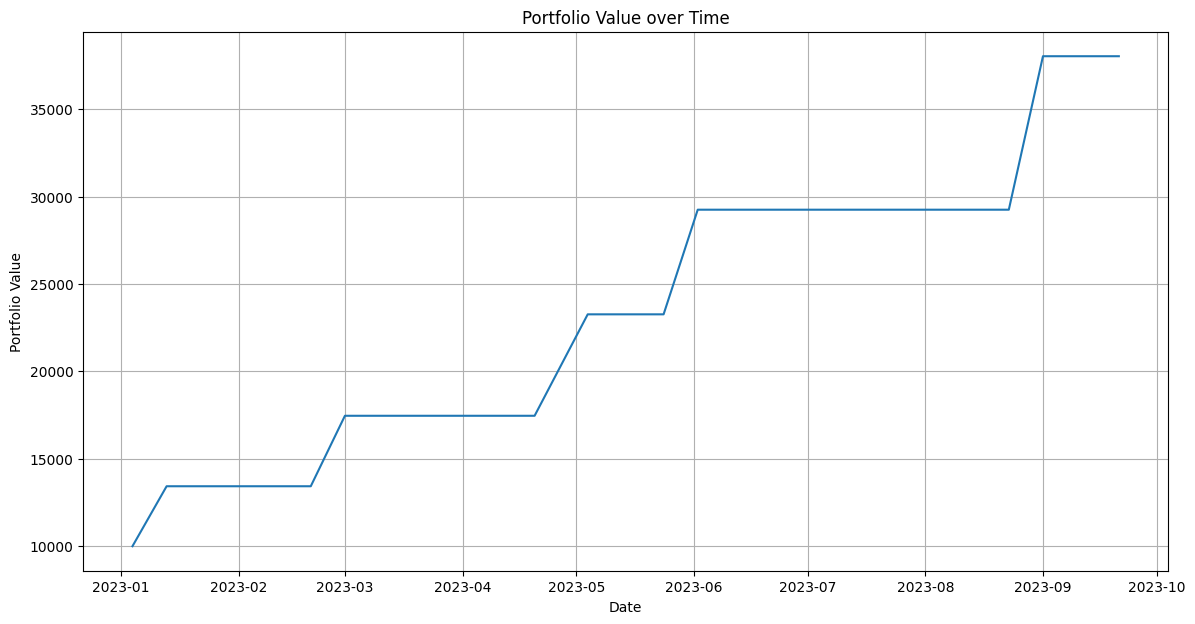

In [40]:
# 画出投资组合价值随时间的变化
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(final_data_2023_cleaned['date'][::investment_period], portfolio_values)
plt.title('Portfolio Value over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.show()